In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/root-newton


In [2]:
%load_ext autoreload
%autoreload 2

import datetime
from collections import defaultdict

import numpy as np
import scipy

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import BaseOracle, LogisticRegressionLoss
from methods import *

In [3]:
def train_loop(w_0: float, dataset_name: str, n_steps: int,
               optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    # dataset
    if dataset_name == "synthetic":
        train_data, train_target = utils.make_synthetic_binary_classification(1000, 100)
    else:
        train_data, train_target = utils.get_LIBSVM(dataset_name)
        from sklearn.preprocessing import normalize
        train_data = normalize(train_data, norm="l2", axis=1)
        
    
    # parameters
    w = np.full((train_data.shape[1]), fill_value=w_0)
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(train_data, train_target, lmd=1e-3)
    
    # e.g. libsvm dataset has {0.0, 1.0} classes that cannot be used for LogisticRegressionLoss 
    # hence they will be remapped to {-1.0, 1.0}
    if isinstance(loss_function, LogisticRegressionLoss):
        train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
        
    for step in range(n_steps):

        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)        
        
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        optim.step(oracle=loss_function)
        
        # print(f"Step: [{step}/{n_steps}] Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
    
    return history

In [4]:
hyperparams = {
    "a1a": {
        "DampedNewton": {"lr": 1.0},
        "AICN": {"L_est": 0.1},
        "RootNewton": {"q": 2.0, "L_est": 0.001},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 1e-5}
    }, 
    "a5a": {
        "DampedNewton": {"lr": 1.0},
        "AICN": {"L_est": 0.1},
        "RootNewton": {"q": 2.0, "L_est": 0.001},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
    }
}

hyperparams_reg = {
    "a1a": {
        "DampedNewton": {"lr": 1.0},
        "AICN": {"L_est": 0.55},
        "RootNewton": {"q": 2.0, "L_est": 0.285},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 0.001}
    }, 
    "mushrooms": {
        "DampedNewton": {"lr": 1.0},
        "AICN": {"L_est": 0.1},
        "RootNewton": {"q": 2.0, "L_est": 0.001},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 0.0001},
    },
    "colon-cancer": {
        "DampedNewton": {"lr": 1.0},
        "AICN": {"L_est": 1.0},
        "RootNewton": {"q": 2.0, "L_est": 0.05},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 0.0001},
    }
}

In [21]:
class GreedyNewton(BaseOptimizer):
    
    def __init__(self, 
                 params: np.ndarray, 
                 lr_range: tuple[float, float] = (1e-5, 1.0), 
                 verbose: bool = False):
        super().__init__(params)
        self.verbose = verbose
        
        self.lrs = np.linspace(lr_range[0], lr_range[1], 50)
        
    def step(self, oracle: BaseOracle) -> np.ndarray:
        """Performs single optimization step.

        Args:
            oracle (BaseOracle): oracle instance with first and second order information.

        Returns:
            np.ndarray:  model parameters after performing optimization step.
        """
        
        loss = oracle.func(self.params)
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        n = np.linalg.solve(hess, grad)
        d = -1.0 * n
        
        best_lr = self.lrs[0]
        min_loss = oracle.func(self.params - best_lr * n)
        for lr in self.lrs[1:]:
            new_loss = oracle.func(self.params - lr * n)
            if new_loss < min_loss:
                min_loss = new_loss
                best_lr = lr
        
        self.lr = best_lr
        
        if self.verbose:
            print(f"{best_lr=}, {min_loss=}")
            
        # Update the parameters
        self.params -= self.lr * n

        return self.params

In [36]:
class Line41(BaseOptimizer):
    
    def __init__(self, 
                 params: np.ndarray, 
                 lr_range: tuple[float, float] = (1e-5, 1.0), 
                 verbose: bool = False):
        super().__init__(params)
        self.verbose = verbose
        
        self.lrs = np.linspace(lr_range[0], lr_range[1], 50)
        
    def step(self, oracle: BaseOracle) -> np.ndarray:
        """Performs single optimization step.

        Args:
            oracle (BaseOracle): oracle instance with first and second order information.

        Returns:
            np.ndarray:  model parameters after performing optimization step.
        """
        
        loss = oracle.func(self.params)
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        n = np.linalg.solve(hess, grad)
        d = -1.0 * n
        
        best_lr = self.lrs[0]
        
        new_params = self.params + best_lr * d
        new_grad = oracle.grad(new_params)
        ny_x = np.linalg.solve(hess, new_grad)
        new_loss = (oracle.func(self.params) - oracle.func(new_params)) / new_grad.dot(ny_x)
        min_loss = new_loss.copy()
        
        for lr in self.lrs[1:]:
            
            new_params = self.params + lr * d
            new_grad = oracle.grad(new_params)
            ny_x = np.linalg.solve(hess, new_grad)
            new_loss = (oracle.func(self.params) - oracle.func(new_params)) / new_grad.dot(ny_x)
            
            if new_loss < min_loss:
                min_loss = new_loss.copy()
                best_lr = lr
        
        self.lr = best_lr
        
        if self.verbose:
            print(f"{best_lr=}, {min_loss=}")

        # Update the parameters
        self.params -= self.lr * n

        return self.params

best_lr=1.0, min_loss=-0.1288677958355039
best_lr=1.0, min_loss=-2.10958989814588
best_lr=1.0, min_loss=-0.2526650894127918
best_lr=1e-05, min_loss=9.999949999949997e-06
best_lr=1e-05, min_loss=9.999949999995002e-06


/home/farshed.abdukhakimov/projects/root-newton/losses.py:67: RuntimeWarning: overflow encountered in square
  rr= r/(1+r)**2


best_lr=1e-05, min_loss=9.99994999999627e-06
best_lr=1e-05, min_loss=9.999950000017694e-06
best_lr=1e-05, min_loss=9.999949999931721e-06
best_lr=1e-05, min_loss=9.999950000121326e-06
best_lr=1e-05, min_loss=9.999949999948432e-06
best_lr=1e-05, min_loss=9.999949999987461e-06
best_lr=1e-05, min_loss=9.99994999998323e-06
best_lr=1e-05, min_loss=9.999949999999633e-06
best_lr=1e-05, min_loss=9.999950000036755e-06
best_lr=1e-05, min_loss=9.999949999967027e-06
best_lr=1e-05, min_loss=9.999950000045829e-06
best_lr=1e-05, min_loss=9.99994999995411e-06
best_lr=1e-05, min_loss=9.999949999947256e-06
best_lr=1e-05, min_loss=9.999950000025349e-06
best_lr=1e-05, min_loss=9.999950000060814e-06
best_lr=1e-05, min_loss=9.999949999926067e-06
best_lr=1e-05, min_loss=9.999950000004175e-06
best_lr=1e-05, min_loss=9.999950000039891e-06
best_lr=1e-05, min_loss=9.99994999996946e-06
best_lr=1e-05, min_loss=9.999950000048302e-06
best_lr=1e-05, min_loss=9.999950000021156e-06
best_lr=1e-05, min_loss=9.999949999888

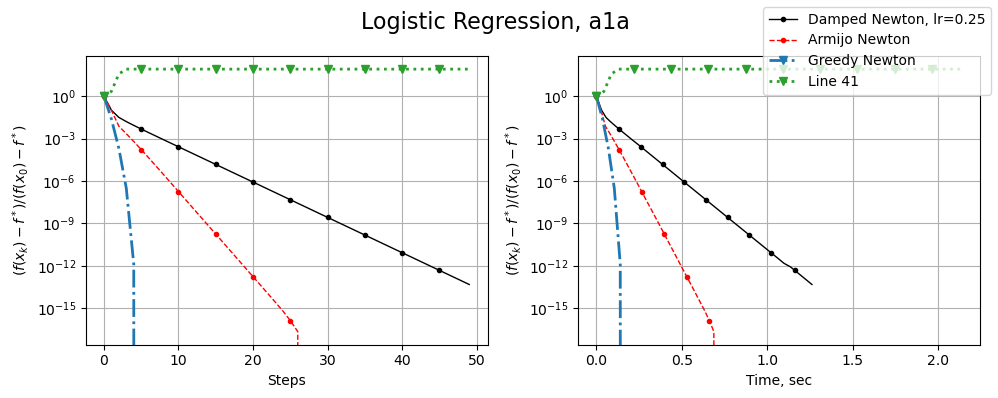

In [49]:
np.random.seed(0)

dataset_name = "a1a"

n_steps = 50

histories = []
labels = []

w_0 = 1.0

# Damped Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps+n_steps, optimizer=DampedNewton, lr=0.25)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Damped Newton, lr=0.25")


# Armijo Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
histories.append(hist)
labels.append(r"Armijo Newton")


# Greedy Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GreedyNewton, verbose=False)
histories.append(hist)
labels.append(r"Greedy Newton")

# Line41
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=Line41, verbose=True)
histories.append(hist)
labels.append(r"Line 41")


utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "v", "p"],
        f_star=f_star, 
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=0.0)